In [303]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time
import matplotlib
from multiprocessing import Pool

In [2]:
def delta_t(l):
    return -math.log(np.random.uniform())/l

In [351]:
def simulate_reactions(v, reaction_net, iterations, verbose=False):
    
    A = reaction_net["stoichiometry"]
    reactants = reaction_net["reactants"]
    reaction_rates = reaction_net["rates"]
    reaction_relations = reaction_net["relations"]
    
    times = [0]
    
    for i in range(iterations):
        
        #get relevant reactants
        reactant_indices = [j for j, item in enumerate(np.ravel(v[-1])) if item !=0]
        cur_reactants = [reactants[j] for j in reactant_indices]
        cur_reactant_amounts = {r: v[-1,j] for j, r in enumerate(reactants)}
        
        #compute possible next reactions
        next_reactions = [rxn for rxn, req in reaction_relations.items() if set(req).issubset(set(cur_reactants))]
        
        #exit if we have there are no possible next reactions:
        if len(next_reactions) == 0:
            break
                
        #compute rxn coefficients for possible next reactions:
        rxn_rates = {rxn: reaction_rates[rxn]*math.exp(sum(map(math.log,[v[-1,reactants.index(r)] for r in reaction_relations[rxn]]))) for rxn in next_reactions}
        
        #compute delta ts:
        dt = {rxn: delta_t(rate) for rxn, rate in rxn_rates.items()}
        
        #find fastest dt:
        while 1:
            next_state = min(dt, key=dt.get)
            update_v = v[-1]+A[:,next_state].T
            if -1 not in np.ravel(update_v):
                break
            else:
                del dt[next_state]
        
        #update times:
        times.append(times[-1] + dt[next_state])
        
        #update v:
        v = np.vstack((v, update_v))
        
        if verbose == True:
            print("v[-1]:", np.ravel(v[-1]))
            print("cur reactants", cur_reactants)
            print("cur_reactant_amounts", cur_reactant_amounts)
            print("next reactions", next_reactions)
            print("rxn_rates", rxn_rates)
            print("dt:", dt)
            print("fastest dt:", min(dt, key=dt.get))
            print()
        
    return times, v, i+1



In [352]:
def plot_simulation(T,V,I, reaction_net, metabolites="all", figsize=(7,3), dpi=170):
    
    A = reaction_net["stoichiometry"]
    reactants = reaction_net["reactants"]
    reaction_rates = reaction_net["rates"]
    reaction_relations = reaction_net["relations"]
    
    start_time = time.time()
    fig, axes = plt.subplots(1,1,figsize=figsize, dpi=dpi)

    cm = plt.get_cmap('jet')
    color_dict = {r: cm(1.*j/A.shape[0]) for j, r in enumerate(reactants)}
    
    #which reactants do we want to plot?
    if metabolites != "all":
        plot_metabolites = [reactants.index(m) for m in metabolites]
    else:
        plot_metabolites = [i for i in range(A.shape[0])]
        metabolites = [r for r in reactants]
    
    for j in plot_metabolites:
        axes.plot(T, np.ravel(V[:,j]), color=color_dict[reactants[j]])
    axes.set_title("{} iterations".format(I))
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.set_xticks([])
    axes.set_xlabel("time")
    axes.set_ylabel("molecules")
    axes.legend(metabolites, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    end_time = time.time()
    print("time elapsed: {} seconds".format(end_time-start_time))

## What simulations should I do later?

1. 25 different initial conditions
2. 50 runs each
3. Get metabolite / time information

## Stochastic model, no flux, no ATP

In [353]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
reaction_rates = [30, 2.637, 1.0, 0.047, 0.045, 0.022, 0.379, 0.15, 0.0098, 0.0049, 0.53, 0.733, 0.4, 0.5, 0.04, 21 ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate"]
reaction_relations = {
    0: ["Glucose"],
    1: ["G6P"],
    2: ["F6P"],
    3: ["F6P"],
    4: ["F1,6BP"],
    5: ["GADP", "DHAP"],
    6: ["DHAP"],
    7: ["GADP"],
    8: ["GADP"],
    9:["1,3BPG"],
    10:["1,3BPG"],
    11:["3PG"],
    12:["2PG"],
    13:["2PG"],
    14:["PEP"],
    15:["PEP"]
}
A = np.matrix(
    [[-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0], # GADP
    [0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0],   # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]    # Pyruvate
)

reaction_net_1 = {"reactants": reactants,
                  "rates": reaction_rates,
                  "relations": reaction_relations,
                  "stoichiometry": A}

time elapsed: 0.1099543571472168 seconds


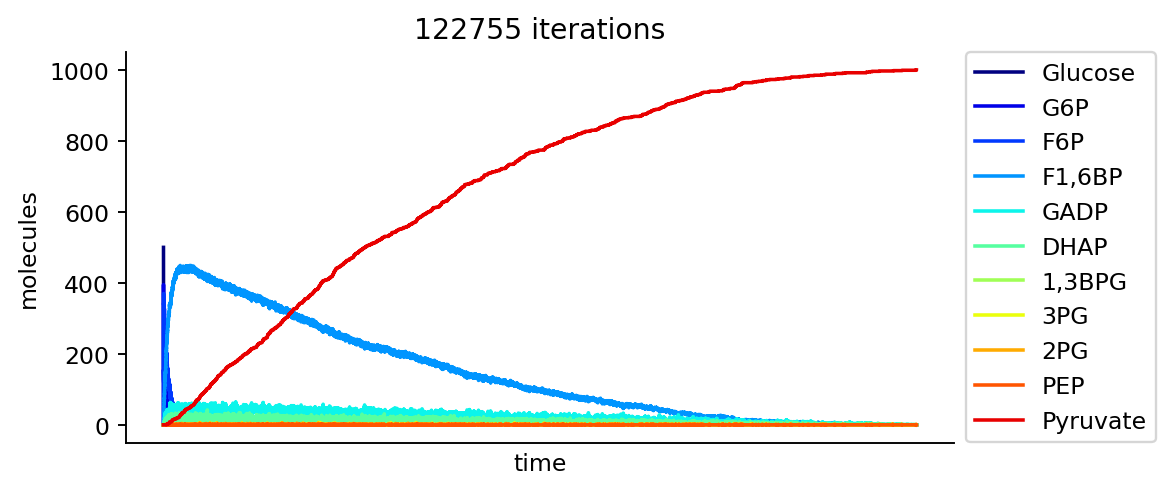

In [355]:
iters = 200000
initial = np.matrix(np.array([500,0,0,0,0,0,0,0,0,0,0]))
T,V,I = simulate_reactions(initial, reaction_net_1, iters)
plot_simulation(T, V, I, reaction_net_1)

## Stochastic simulation, no flux, with ATP

In [357]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
reaction_rates = [30, 2.637, 1.0, 0.047, 0.045, 0.022, 0.379, 0.15, 0.0098, 0.0049, 0.53, 0.733, 0.4, 0.5, 0.04, 21 ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate", "ATP", "ADP"]
reaction_relations = {
    0: ["Glucose", "ATP"],
    1: ["G6P"],
    2: ["F6P"],
    3: ["F6P", "ATP"],
    4: ["F1,6BP"],
    5: ["GADP", "DHAP"],
    6: ["DHAP"],
    7: ["GADP"],
    8: ["GADP"],
    9:["1,3BPG"],
    10:["1,3BPG", "ADP"],
    11:["3PG"],
    12:["2PG"],
    13:["2PG"],
    14:["PEP"],
    15:["PEP", "ADP"]
}
A = np.matrix(
    [[-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0], # GADP
    [0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0],   # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],    # Pyruvate
    [-1,0,0,-1,0,0,0,0,0,0,2,0,0,0,0,2],  # ATP
    [1,0,0,1,0,0,0,0,0,0,-2,0,0,0,0,-2]]  # ADP 
)

reaction_net_2 = {"reactants": reactants,
                  "rates": reaction_rates,
                  "relations": reaction_relations,
                  "stoichiometry": A}

## Initial conditions of the stochastic glycolysis reaction network model with ATP

Given the net Glycolysis reaction,

$ G + 2ATP \rightarrow 2Pyruvate + 4ATP $

it would make sense if we could simply inititialize the system with $ N_{\rm ATP} = 2N_G $.

However, due to the stochastic nature of how these simulated reactions are proceeding, we run into a problem where all of the ADP generated in the beginning of the Glycolysis reaction cascade could be exhausted in reaction 7, as seen in the following figure from Lehninger Principles of Biochemistry.

<img src="glyco.png" alt="drawing" height="650" width="650"/>

If this were the case, we would not see the full conversion of $ G + 2ATP \rightarrow 2Pyruvate + 4ATP $. We expect to observe full depletion of ADP molecules, and a subsequent halt of ATP and Pyruvate production. We run our stochastic reaction network model using the following initial conditions:

* $ N_G = 50 $ 
* $ N_{\rm ATP} = 2N_G = 100$ 
* $ I_{\rm max} = 3000$

All other metabolites have been initialized to zero molecules.

time elapsed: 0.059603214263916016 seconds


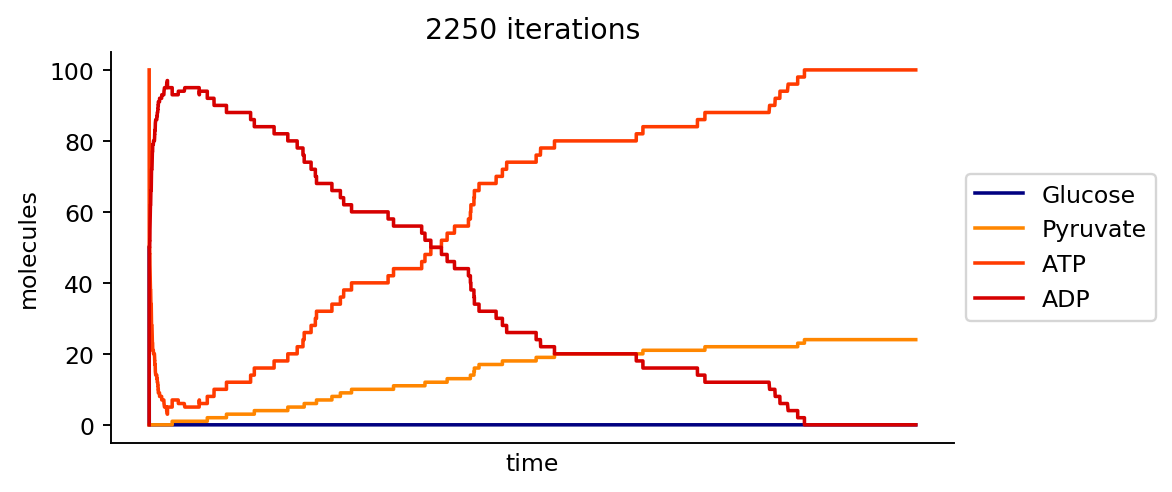

In [358]:
initial = np.matrix(np.array([50,0,0,0,0,0,0,0,0,0,0,100,0]))
iters = 2250
T, V, I = simulate_reactions(initial, reaction_net_2, iters)
plot_simulation(T,V,I, reaction_net_2, metabolites=["Glucose", "Pyruvate", "ATP", "ADP"])

**We make the following observations based on this simulation:**

* We do not observe a full conversion of $ N_G   \rightarrow 2N_{\rm Pyruvate}$

* At the start of the reaction, we see a rapid conversion of almost all of the ATP molecules into ADP, followed by a slower conversion back from ADP to ATP. As expected, we observe an exhaustion of the supply of ADP molecules, thus the final reaction $ PEP + 2ADP \rightarrow Pyruvate + 2ATP $ cannot proceed.

* The simulation is programmed to stop when the maximum number of iterations has occurred, or if there are no more possible reactions. In this case, the intermediate metabolites (not shown in the above plot) are fluctuating while glucose, pyruvate, ATP, and ADP remain stable.

In a real biological system, free ATP and ADP exist floating around the cell that were not directly created or destroyed as a consequence of this reaction network. Since we are not considering any flux of metabolites in or out of the reaction network, we can simply **initialize $ N_{\rm ADP} $ to some sufficiently large value**, representing a pool of ADP existing throughout the cell, such that our model fully converts $ N_G   \rightarrow 2N_{\rm Pyruvate}$. 

Now, we run the stochastic reaction network model for the following initial conditions:

* $ N_G = 50 $ 
* $ N_{\rm ATP} = 2N_G = 100$ 
* $ N_{\rm ADP} = 6N_G = 300$
* $ I_{\rm max} = 10000$


time elapsed: 0.034549713134765625 seconds


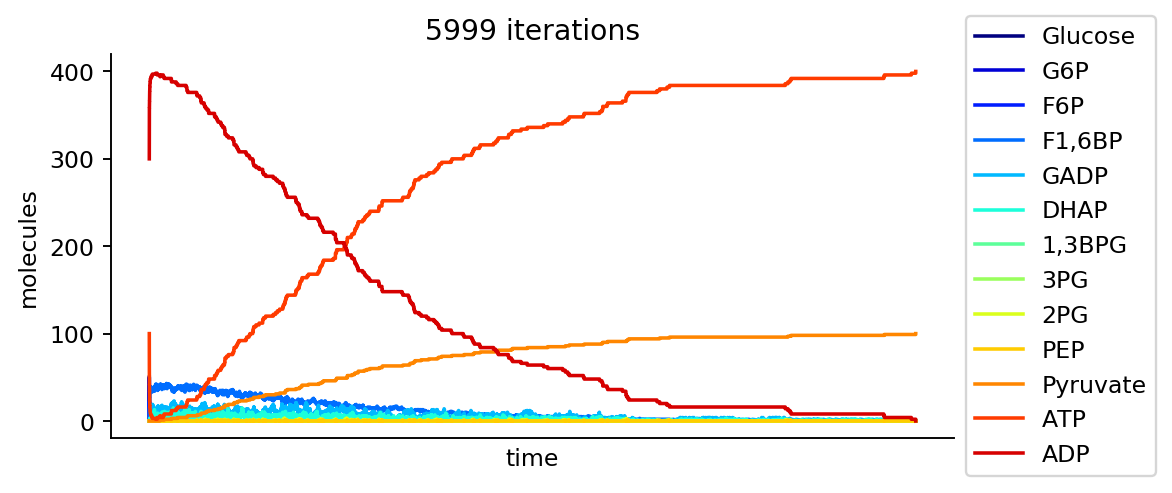

In [360]:
initial = np.matrix(np.array([50,0,0,0,0,0,0,0,0,0,0,100,300]))
iters = 30000
T, V, I = simulate_reactions(initial, reaction_net_2, iters )
plot_simulation(T,V,I, reaction_net_2)

**We make the following observations from this simulation:**

* The simulation terminated when there are no more possible reactions to proceed to, $ I_{sim} < I_{\rm max}$, thus we can say that this system has converged to a steady state.

* We observe the expected amount of pyruvate generated as dictated by the glycolysis net reaction, $ E_{\rm Pyruvate} = n_{\rm Pyruvate} = 2N_G$

* We observe a final amount of ATP generated eight times larger than expected based on the glycolysis net reaction. $ n_{\rm ATP} = 8N_G \neq E_{\rm ATP}$

* We observe a final amount of ATP equal to $ n_{\rm ATP} = N_{\rm ATP} + N_{\rm ADP}$ and a final amount of ADP equal to $ n_{\rm ADP} = 0 $.

From our initial conditions, we expect to produce 100 molecules of pyruvate from 50 molecules of glucose. From reactions 7 and 10, as seen in the figure above from Lehninger, the expenditure of 4 ADP molecules is required to produce one pyruvate. Thus, for these initial conditions, we require 400 molecules of ADP in order to achieve the desired 100 molecules of pyruvate.

## Stochastic simulation, with ATP, and flux of glucose, pyruvate

In [365]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
glucose_rate = 0.01
pyruvate_rate = 0.01
reaction_rates = [glucose_rate, 30, 2.637, 1.0, 0.047, 0.045, 0.022, 0.379, 0.15, 0.0098, 0.0049, 0.53, 0.733, 0.4, 0.5, 0.04, 21, pyruvate_rate ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate", "ATP", "ADP"]
reaction_relations = {
    0: [],
    1: ["Glucose", "ATP"],
    2: ["G6P"],
    3: ["F6P"],
    4: ["F6P", "ATP"],
    5: ["F1,6BP"],
    6: ["GADP", "DHAP"],
    7: ["DHAP"],
    8: ["GADP"],
    9: ["GADP"],
    10:["1,3BPG"],
    11:["1,3BPG", "ADP"],
    12:["3PG"],
    13:["2PG"],
    14:["2PG"],
    15:["PEP"],
    16:["PEP", "ADP"],
    17:["Pyruvate"]
}
A = np.matrix(
    [[1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0,0], # GADP
    [0,0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,0],   # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,0],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1],   # Pyruvate
    [0,-1,0,0,-1,0,0,0,0,0,0,2,0,0,0,0,2,0],  # ATP
    [0,1,0,0,1,0,0,0,0,0,0,-2,0,0,0,0,-2,0]]  # ADP 
)

reaction_net_3 = {"reactants": reactants,
                  "rates": reaction_rates,
                  "relations": reaction_relations,
                  "stoichiometry": A}


time elapsed: 0.06590533256530762 seconds


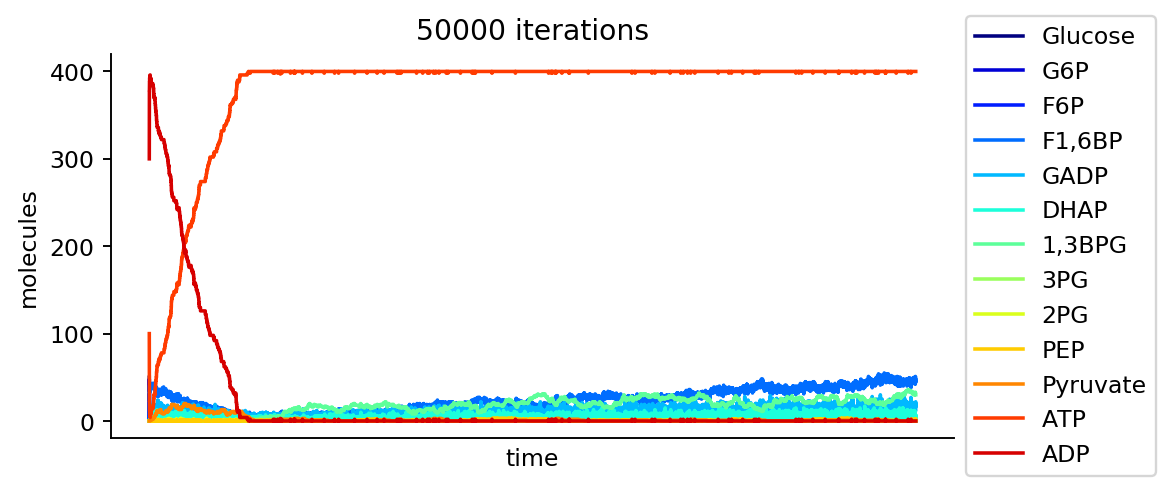

In [364]:
initial = np.matrix(np.array([50,0,0,0,0,0,0,0,0,0,0,100,300]))
iters = 50000
T, V, I = simulate_reactions(initial, reaction_net_3, iters )
plot_simulation(T,V,I, reaction_net_3)

## Stochastic simulation, with flux of Glucose, Pyruvate, ATP, and ADP

In [369]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
glucose_rate = 0.01
pyruvate_rate = 0.01
ATP_in = 0.0001
ATP_out = 0.0001
ADP_in = 0.001
ADP_out = 0.0001
reaction_rates = [glucose_rate, 30, 2.637, 1.0, 0.047, 0.045, 0.022, 0.379, 0.15, 0.0098, 0.0049, 0.53, 0.733, 0.4, 0.5, 0.04, 21, pyruvate_rate, ATP_in, ATP_out, ADP_in, ADP_out ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate", "ATP", "ADP"]
reaction_relations = {
    0: [],
    1: ["Glucose", "ATP"],
    2: ["G6P"],
    3: ["F6P"],
    4: ["F6P", "ATP"],
    5: ["F1,6BP"],
    6: ["GADP", "DHAP"],
    7: ["DHAP"],
    8: ["GADP"],
    9: ["GADP"],
    10:["1,3BPG"],
    11:["1,3BPG", "ADP"],
    12:["3PG"],
    13:["2PG"],
    14:["2PG"],
    15:["PEP"],
    16:["PEP", "ADP"],
    17:["Pyruvate"],
    18:[],
    19:[],
    20:[],
    21:[],
}
A = np.matrix(
    [[1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0,0,0,0,0,0], # GADP
    [0,0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,0,0,0,0,0],   # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0,0,0,0,0,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0],   # Pyruvate
    [0,-1,0,0,-1,0,0,0,0,0,0,2,0,0,0,0,2,0,1,-1,0,0],  # ATP
    [0,1,0,0,1,0,0,0,0,0,0,-2,0,0,0,0,-2,0,0,0,1,-1]]  # ADP 
)

reaction_net_4 = {"reactants": reactants,
                  "rates": reaction_rates,
                  "relations": reaction_relations,
                  "stoichiometry": A}

time elapsed: 0.03920578956604004 seconds


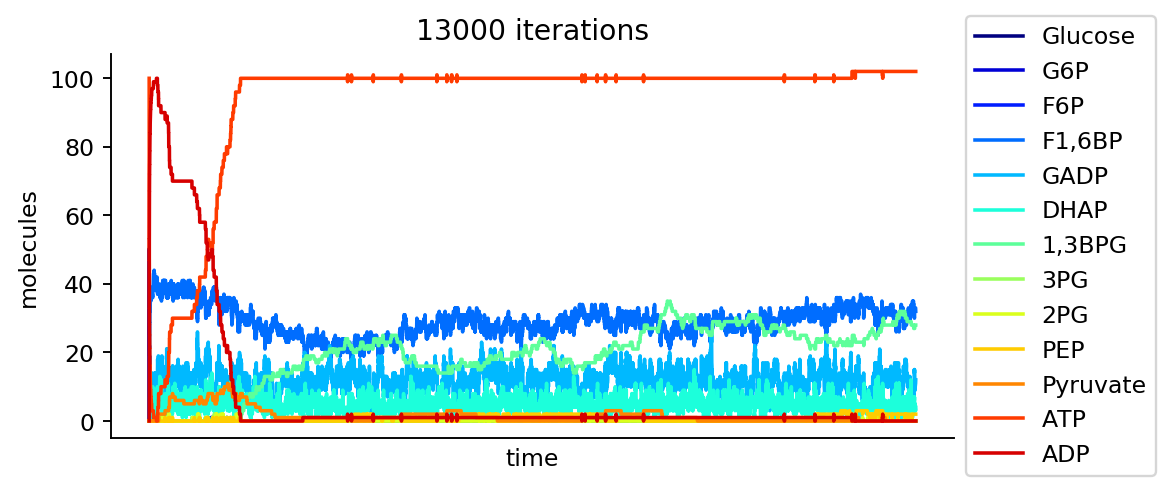

In [370]:
initial = np.matrix(np.array([50,0,0,0,0,0,0,0,0,0,0,100,0]))
iters = 13000
T, V, I = simulate_reactions(initial, reaction_net_4, iters )
plot_simulation(T,V,I, reaction_net_4)

## Run multuple simulations of each model for different initial conditions:


**No ATP model:**


In [ ]:
no_ATP_output = []
iters = 50000000
for starting_glucose in [5, 10, 50, 100, 250, 500, 750, 1000]:
    init_conditions_ = [[np.matrix(np.array([starting_glucose,0,0,0,0,0,0,0,0,0,0]))] for n in range(100)]
    with Pool(16) as pool:
        no_ATP_output.append(pool.starmap(simulate_reactions, [[init[0], reaction_net_1, iters] for init in initial_conditions]))

**With ATP model:**

In [ ]:
with_ATP_output = []
iters = 50000000
for starting_glucose in [5, 10, 50, 100, 250, 500, 750, 1000]:
    init_conditions_ = [[np.matrix(np.array([starting_glucose,0,0,0,0,0,0,0,0,0,0,2*starting_glucose, 6*starting_glucose]))] for n in range(100)]
    with pool(16) as pool:
        with_ATP_output.append(pool.starmap(simulate_reactions, [[init[0], reaction_net_2, iters] for init in initial_conditions]))

**With Flux model:**

In [ ]:
with_ATP_output = []
iters = 10000000
for starting_glucose in [5, 10, 50, 100, 250, 500, 750, 1000]:
    init_conditions_ = [[np.matrix(np.array([starting_glucose,0,0,0,0,0,0,0,0,0,0,2*starting_glucose, 6*starting_glucose]))] for n in range(100)]
    with pool(16) as pool:
        with_ATP_output.append(pool.starmap(simulate_reactions, [[init[0], reaction_net_2, iters] for init in initial_conditions]))

In [345]:
T, V, I = output[3][0], output[3][1], output[3][2]

time elapsed: 0.19741535186767578 seconds


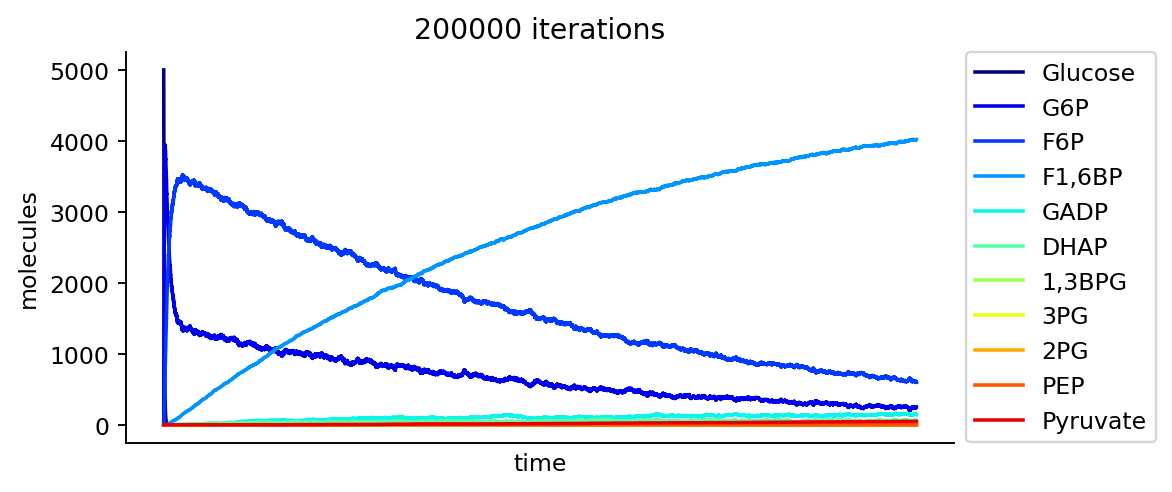

In [346]:
plot_simulation(T,V,I, reaction_net_1)